# Section 1 – Data exploration and pre-processing



Import required libraries

In [33]:
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


### 1. Investigate the provided DDoS attack dataset.

Load dataset and drop null columns that don´t provide any information

In [34]:
df = pd.read_csv('ddos_dataset.csv',low_memory = False)
df.columns = df.columns.str.strip()

null_columns = df.columns[df.eq(0).all()]
df = df.drop(columns = null_columns)
print(f"columns dropped for their lack of information\n{null_columns}")
print(f"The dataset contains {len(df)} datapoints")

columns dropped for their lack of information
Index(['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count',
       'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')
The dataset contains 64239 datapoints


#### Analyse Label distribution in the dataset

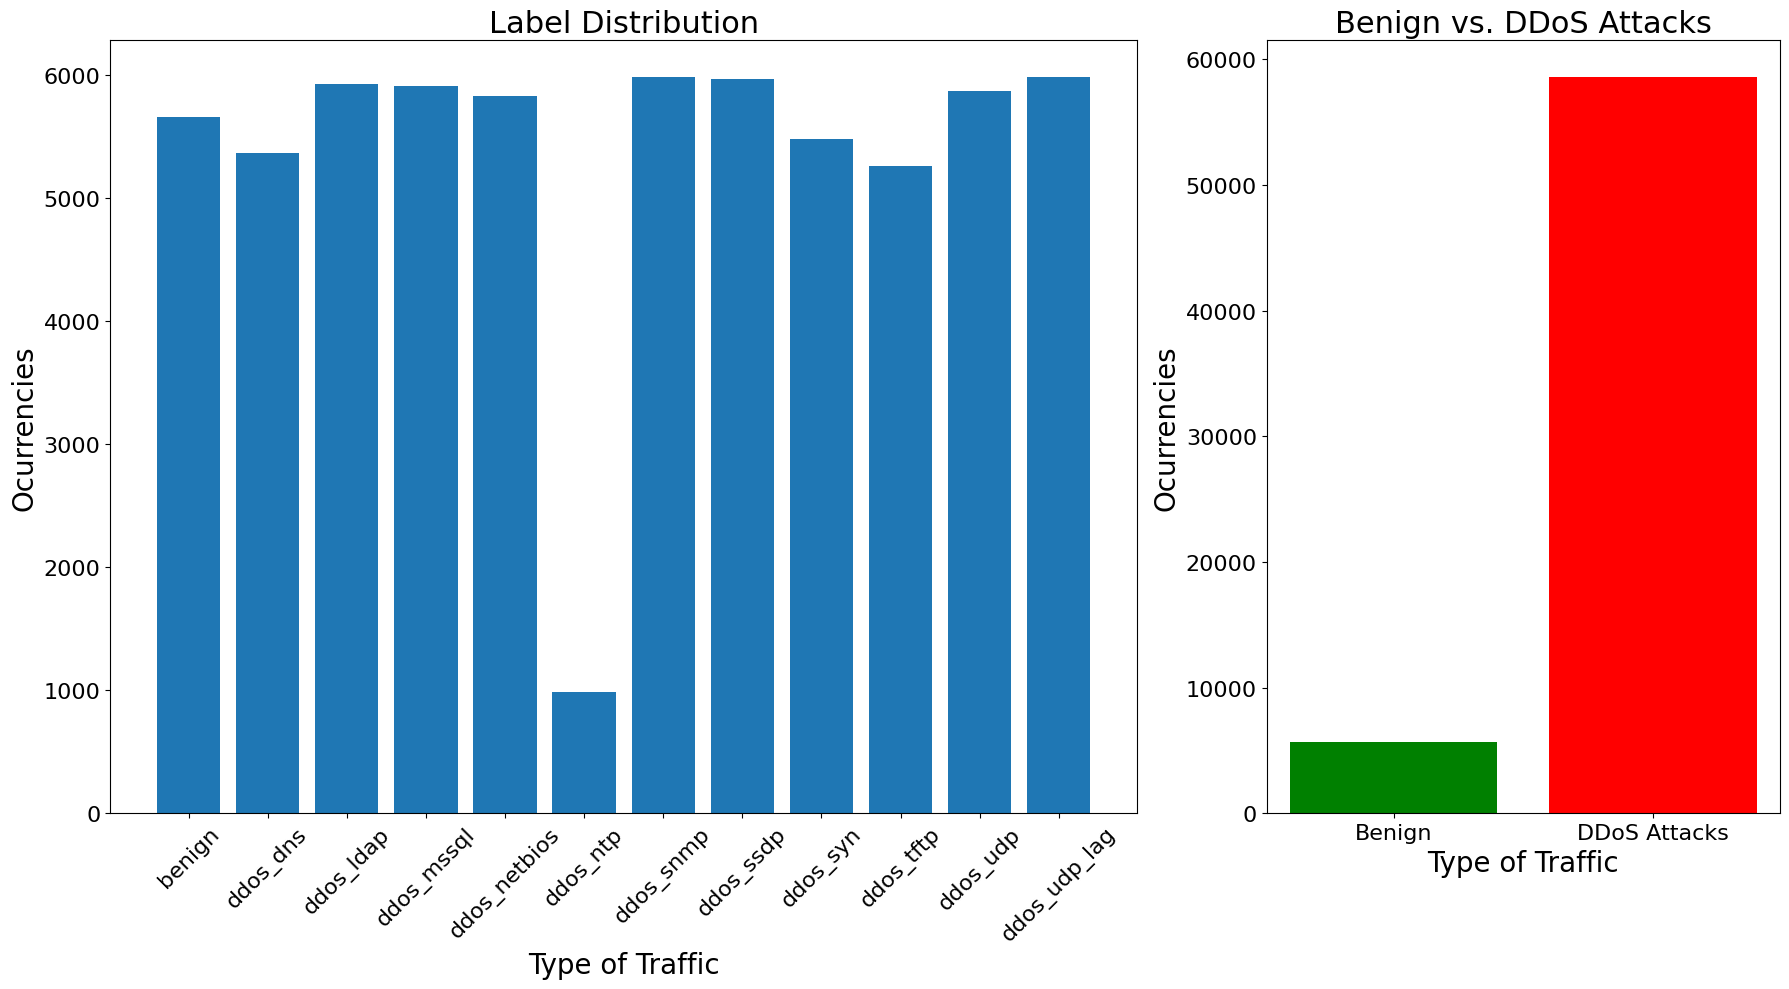

In [35]:
grouped_df = df.groupby('label')
dic = {}
for key, group_df in grouped_df:
    dic[key] = group_df.shape[0]
labels = list(dic.keys())
x = np.arange(len(labels))
values = list(dic.values())

benign_count = dic.get('benign', 0)
ddos_attacks_count = sum(values) - benign_count

fig, axs = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [2, 1]})

axs[0].bar(x, values, tick_label=labels)
axs[0].tick_params(axis='x', rotation=45, labelsize=16)
axs[0].tick_params(axis='y', labelsize=16)  
axs[0].set_title('Label Distribution', fontsize=22)
axs[0].set_ylabel('Ocurrencies', fontsize=20)
axs[0].set_xlabel('Type of Traffic', fontsize=20)

categories = ['Benign', 'DDoS Attacks']
category_values = [benign_count, ddos_attacks_count]
axs[1].bar(categories, category_values, color=['green', 'red'])
axs[1].tick_params(axis='y', labelsize=16) 
axs[1].tick_params(axis='x', labelsize=16) 
axs[1].set_title('Benign vs. DDoS Attacks', fontsize=22)
axs[1].set_ylabel('Ocurrencies', fontsize=20)
axs[1].set_xlabel('Type of Traffic', fontsize=20)

plt.tight_layout()
plt.show()




#### Analyse Features Distribution


Protocol

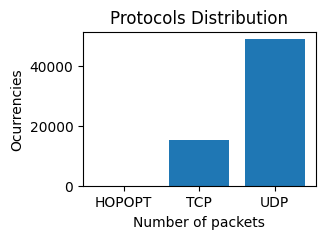

In [36]:
prt_df = df.groupby('Protocol')
dic = {}
for key, group_df in prt_df:
    dic[key] = group_df.shape[0]
protocol_names = {
    0: 'HOPOPT',  # IPv6 Hop-by-Hop
    6: 'TCP',     # TCP
    17: 'UDP'     # UDP
}
labels = [protocol_names.get(key, str(key)) for key in dic.keys()]
x = np.arange(len(labels))
values = list(dic.values())
fig, ax = plt.subplots(figsize=(3, 2))
ax.bar(x, values, tick_label=labels)

plt.title('Protocols Distribution')
ax.set_xlabel('Number of packets')
ax.set_ylabel('Ocurrencies')
plt.show()


Total Fwd Packets

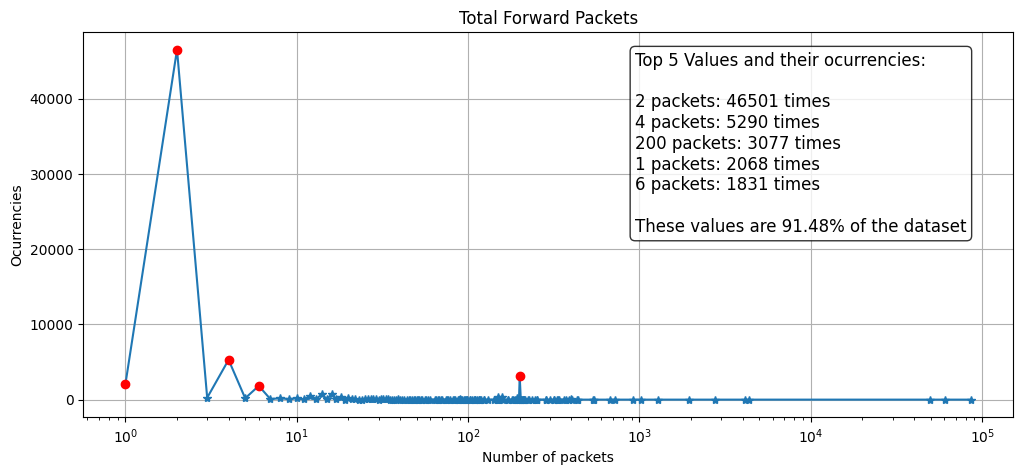

In [37]:
pck_f = df.groupby('Total Fwd Packets')
dic1 = {}
li = []
li1 = []
for numb, group_df_prot in pck_f:
    li.append(numb)
    li1.append(group_df_prot.shape[0])
dic1['value'] = li1
pck_f_df = pd.DataFrame(data=dic1, index=li)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(pck_f_df, marker='*')
ax.set_xscale('log')
ax.set_title('Total Forward Packets')
ax.set_xlabel('Number of packets')
ax.set_ylabel('Ocurrencies')
ax.grid()

# TOP values representation
top_5 = pck_f_df.nlargest(5, 'value')
top_5_percentage = top_5['value'].sum() / pck_f_df['value'].sum() * 100
top_5_text = "\n".join([f"{index} packets: {value} times" for index, value in top_5['value'].items()])
percentage_text = f"These values are {top_5_percentage:.2f}% of the dataset"
ax.text(
    0.95, 0.95, f"Top 5 Values and their ocurrencies:\n\n{top_5_text}\n\n{percentage_text}",
    transform=ax.transAxes,
    fontsize=12,
    va='top',
    ha='right',
    multialignment='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
ax.scatter(top_5.index, top_5['value'], color='red', label='Top 5 Points', zorder=5)
plt.show()


Total Backward Packets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


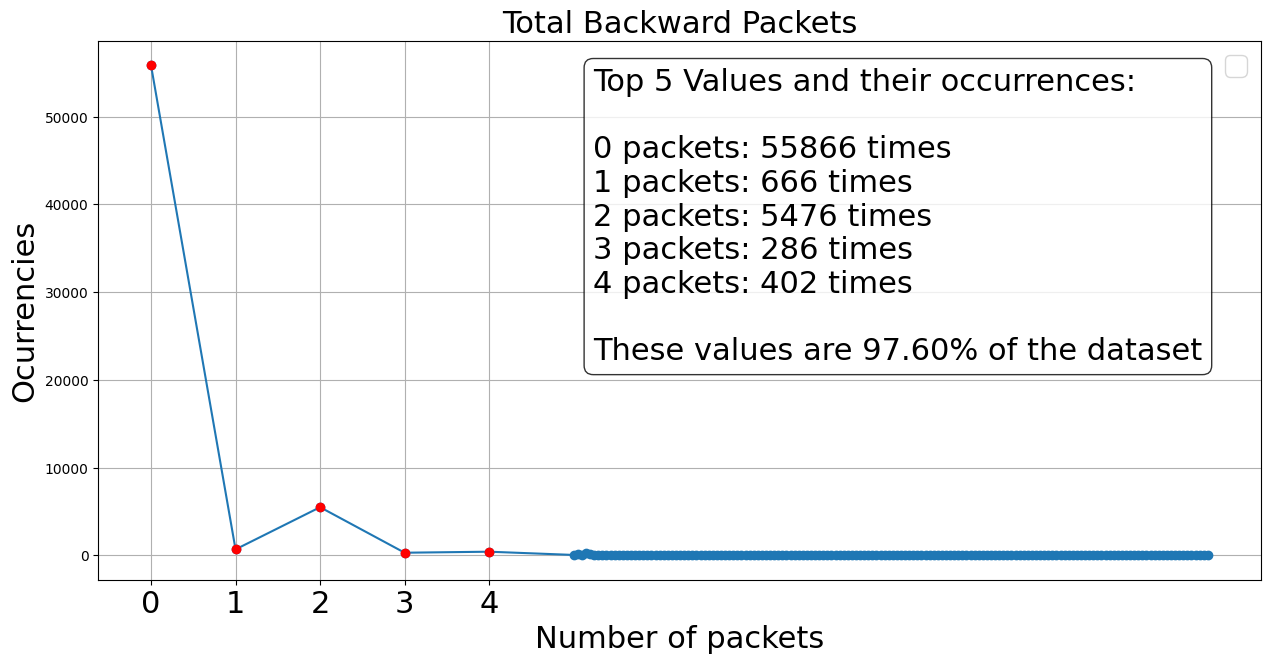

In [38]:
pck_f = df.groupby('Total Backward Packets')
dic1 = {}
li = []
li1 = []
for numb, group_df_prot in pck_f:
    li.append(numb)
    li1.append(group_df_prot.shape[0])
dic1['value'] = li1
pck_f_df = pd.DataFrame(data=dic1, index=li)


top_5 = pck_f_df.iloc[:5]  
remaining = pck_f_df.iloc[5:]
top_5_space = np.linspace(0, 0.4, len(top_5), endpoint=False)
remaining_space = np.linspace(0.4, 1, len(remaining))
x_positions = np.concatenate([top_5_space, remaining_space])

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(x_positions, pd.concat([top_5, remaining])['value'], marker='o')
ax.set_title('Total Backward Packets', fontsize=22)
xticks_positions = list(top_5_space)
xticks_labels = list(top_5.index)
ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels, fontsize=22)
ax.set_xlabel('Number of packets', fontsize=22)
ax.set_ylabel('Ocurrencies', fontsize=22)
ax.grid()

top_5_percentage = top_5['value'].sum() / pck_f_df['value'].sum() * 100
top_5_text = "\n".join(
    [f"{index} packets: {value} times" for index, value in top_5['value'].items()]
)
percentage_text = f"These values are {top_5_percentage:.2f}% of the dataset"
ax.text(
    0.95, 0.95, f"Top 5 Values and their occurrences:\n\n{top_5_text}\n\n{percentage_text}",
    transform=ax.transAxes,
    fontsize=22,
    va='top',
    ha='right',
    multialignment='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
ax.scatter(top_5_space, top_5['value'], color='red', zorder=5)

ax.legend(fontsize=20)

plt.show()



Total Length of Fwd Packets

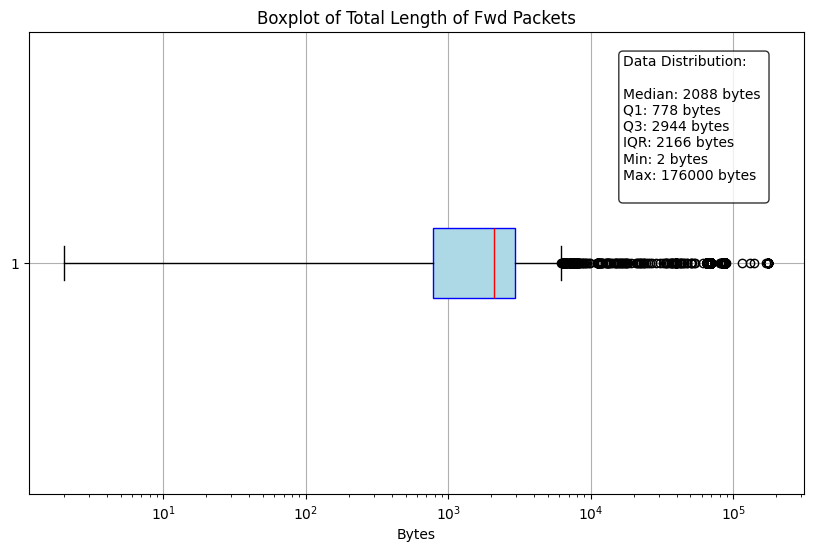

Top 5 Most Common Values:
2944 bytes: 15293 times
458 bytes: 5018 times
88000 bytes: 3077 times
1438 bytes: 1787 times
1398 bytes: 1776 times


In [39]:
len_f = df.groupby('Total Length of Fwd Packets')
dic1 = {}
li = []
li1 = []
for numb, group_df_prot in len_f:
    li.append(numb)
    li1.append(group_df_prot.shape[0])
dic1['value'] = li1
pck_f_df = pd.DataFrame(data=dic1, index=li)

pck_f_df_non_zero = pck_f_df[pck_f_df.index > 0]
packet_lengths = np.repeat(pck_f_df_non_zero.index, pck_f_df_non_zero['value'])
median = np.median(packet_lengths)
q1 = np.percentile(packet_lengths, 25)
q3 = np.percentile(packet_lengths, 75)
iqr = q3 - q1
min_value = np.min(packet_lengths)
max_value = np.max(packet_lengths)


fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(packet_lengths, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
ax.set_title('Boxplot of Total Length of Fwd Packets')
ax.set_xlabel('Bytes')
ax.set_xscale('log')
ax.grid(True)

data_distribution = f"Median: {int(median)} bytes \n"
data_distribution += f"Q1: {int(q1)} bytes\n"
data_distribution += f"Q3: {int(q3)} bytes\n"
data_distribution += f"IQR: {int(iqr)} bytes\n"
data_distribution += f"Min: {int(min_value)} bytes\n"
data_distribution += f"Max: {int(max_value)} bytes\n"
ax.text(0.95, 0.95, f"Data Distribution:\n\n{data_distribution}",
        transform=ax.transAxes, fontsize=10, va='top', ha='right',
        multialignment='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

top_5 = pck_f_df_non_zero['value'].nlargest(5)
print("Top 5 Most Common Values:")
for value, count in top_5.items():
    print(f"{int(value)} bytes: {count} times")


Total Length of Bwd Packets

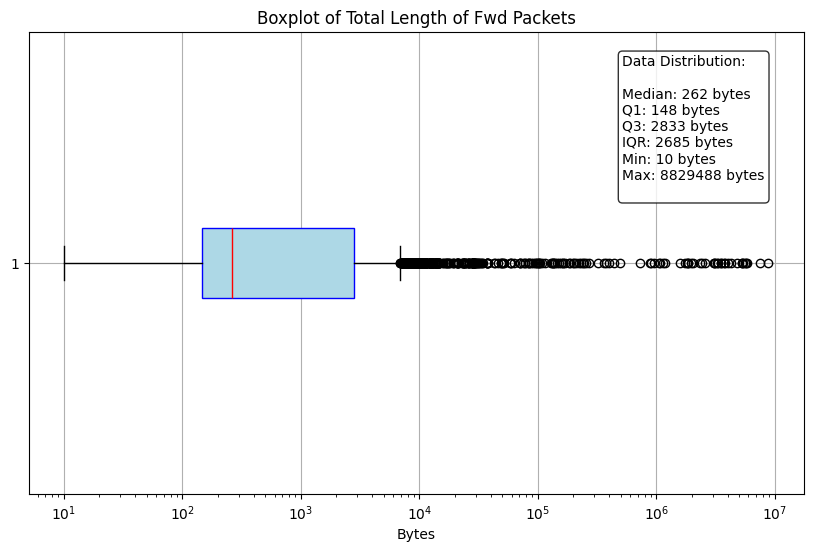

Top 5 Most Common Values:
204 bytes: 107 times
4290 bytes: 98 times
2146 bytes: 96 times
116 bytes: 82 times
118 bytes: 74 times


In [40]:
len_b = df.groupby('Total Length of Bwd Packets')
dic1 = {}
li = []
li1 = []
for numb, group_df_prot in len_b:
    li.append(numb)
    li1.append(group_df_prot.shape[0])
dic1['value'] = li1
pck_f_df = pd.DataFrame(data=dic1, index=li)

pck_f_df_non_zero = pck_f_df[pck_f_df.index > 0]
packet_lengths = np.repeat(pck_f_df_non_zero.index, pck_f_df_non_zero['value'])
median = np.median(packet_lengths)
q1 = np.percentile(packet_lengths, 25)
q3 = np.percentile(packet_lengths, 75)
iqr = q3 - q1
min_value = np.min(packet_lengths)
max_value = np.max(packet_lengths)


fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(packet_lengths, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
ax.set_title('Boxplot of Total Length of Fwd Packets')
ax.set_xlabel('Bytes')
ax.set_xscale('log')
ax.grid(True)

data_distribution = f"Median: {int(median)} bytes \n"
data_distribution += f"Q1: {int(q1)} bytes\n"
data_distribution += f"Q3: {int(q3)} bytes\n"
data_distribution += f"IQR: {int(iqr)} bytes\n"
data_distribution += f"Min: {int(min_value)} bytes\n"
data_distribution += f"Max: {int(max_value)} bytes\n"
ax.text(0.95, 0.95, f"Data Distribution:\n\n{data_distribution}",
        transform=ax.transAxes, fontsize=10, va='top', ha='right',
        multialignment='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

top_5 = pck_f_df_non_zero['value'].nlargest(5)
print("Top 5 Most Common Values:")
for value, count in top_5.items():
    print(f"{int(value)} bytes: {count} times")


Destination Port

C:\Users\alvar\AppData\Local\Temp\ipykernel_9904\2714397756.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=22)


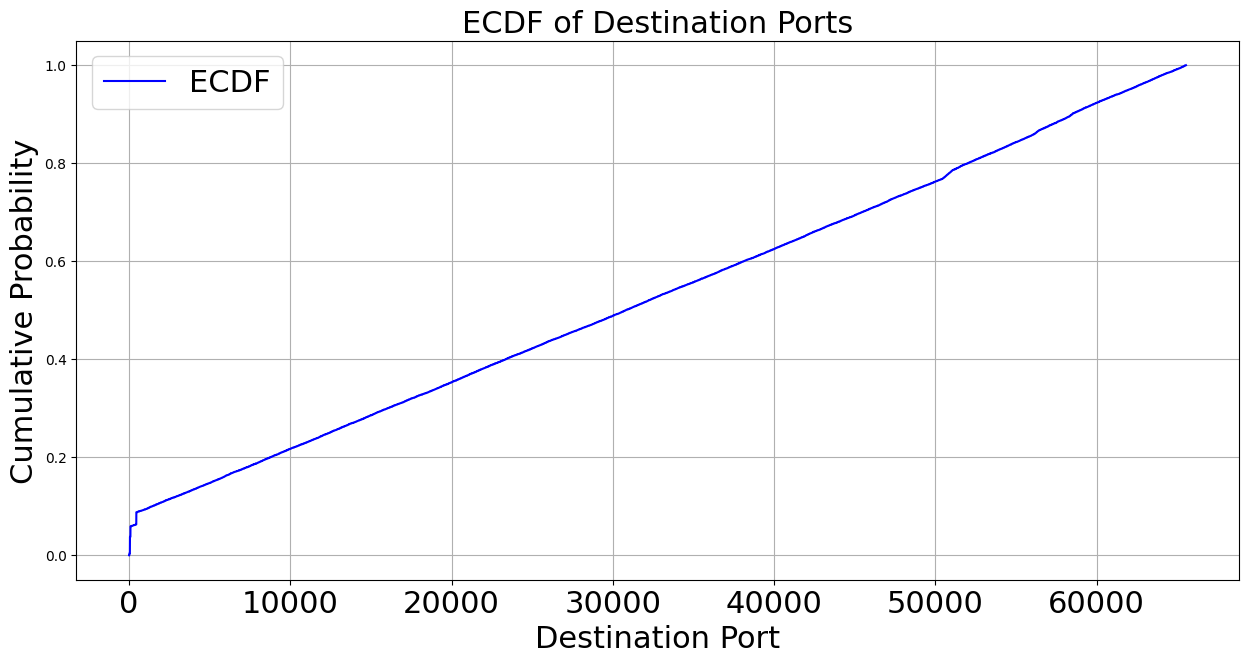

In [41]:
dest = df.groupby('Destination Port')
dic1 = {}
li = []
li1 = []
for numb, group_df_prot in dest:
    li.append(numb)
    li1.append(group_df_prot.shape[0])

dic1['value'] = li1
pck_f_df = pd.DataFrame(data=dic1, index=li)

data_for_ecdf = np.repeat(pck_f_df.index, pck_f_df['value'])
ecdf = ECDF(data_for_ecdf)

fig, ax = plt.subplots(figsize=(15, 7))
ax.step(ecdf.x, ecdf.y, where='post', label='ECDF', color='blue')
ax.set_title('ECDF of Destination Ports', fontsize=22)
ax.set_xlabel('Destination Port', fontsize=22)
ax.set_ylabel('Cumulative Probability', fontsize=22)
ax.grid(True)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=22)
ax.legend(fontsize=22)

plt.show()


Flow Duration

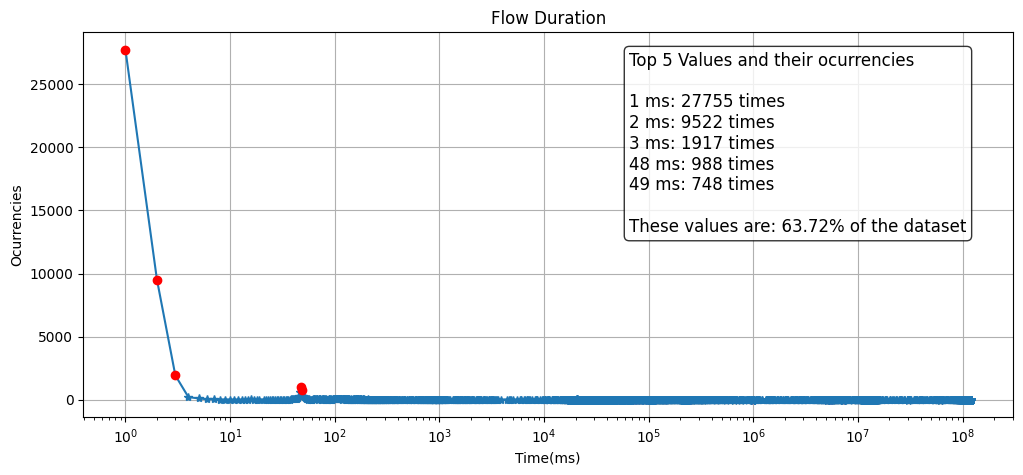

In [42]:
pck_f = df.groupby('Flow Duration')
dic1 = {}
li = []
li1 = []
for numb, group_df_prot in pck_f:
    li.append(numb)
    li1.append(group_df_prot.shape[0])
dic1['value'] = li1
pck_f_df = pd.DataFrame(data=dic1, index=li)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(pck_f_df, marker='*')
ax.set_xscale('log')
ax.set_title('Flow Duration')
ax.set_xlabel('Time(ms)')
ax.set_ylabel('Ocurrencies')
ax.grid()

top_5 = pck_f_df.nlargest(5, 'value')
top_5_percentage = top_5['value'].sum() / pck_f_df['value'].sum() * 100
top_5_text = "\n".join([f"{index} ms: {value} times" for index, value in top_5['value'].items()])
percentage_text = f"These values are: {top_5_percentage:.2f}% of the dataset"
ax.text(
    0.95, 0.95, f"Top 5 Values and their ocurrencies\n\n{top_5_text}\n\n{percentage_text}",
    transform=ax.transAxes,
    fontsize=12,
    va='top',
    ha='right',
    multialignment='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
ax.scatter(top_5.index, top_5['value'], color='red', label='Top 5 Points', zorder=5)
plt.show()

#### Analysis of features for each attack

In [43]:
# Group the DataFrame by 'Label'
grouped = df.groupby('label')
# Create a list of DataFrames
list_of_dfs = [group for _, group in grouped]
labels = df['label'].unique()
print(labels)

df_dict = {}
for i in range(0,12):
    df_dict[labels[i]] = list_of_dfs[i]

['ddos_dns' 'benign' 'ddos_ldap' 'ddos_mssql' 'ddos_netbios' 'ddos_ntp'
 'ddos_snmp' 'ddos_ssdp' 'ddos_udp' 'ddos_syn' 'ddos_tftp' 'ddos_udp_lag']


Protocol per Label

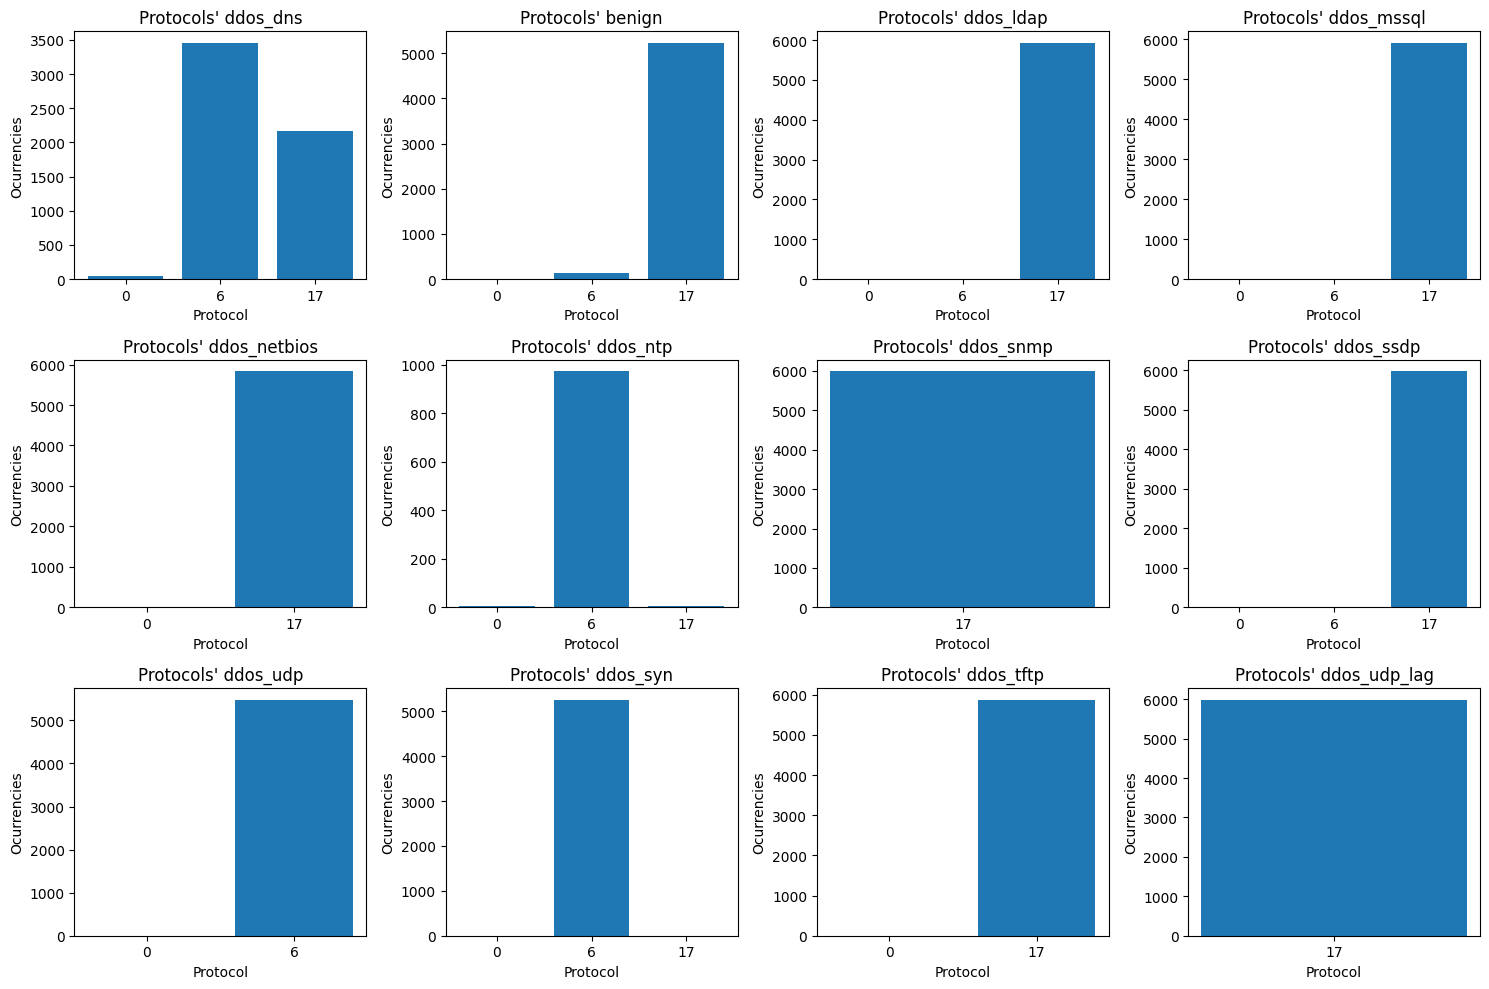

In [44]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

axes = axes.flatten()

for i, (label, df_) in enumerate(zip(df_dict.keys(), df_dict.values())):
    df_ = df_.groupby('Protocol')
    dic = {}
    for key, group_df in df_:
        dic[key] = group_df.shape[0]
    
    labels_in = list(dic.keys())
    x = np.arange(len(labels_in))
    values = list(dic.values())
    
    ax = axes[i]
    ax.bar(x, values, tick_label=labels_in)
    ax.set_title(f'Protocols\' {label}')
    ax.set_xlabel("Protocol")
    ax.set_ylabel("Ocurrencies")

plt.tight_layout()

plt.show()


Source Port per Label

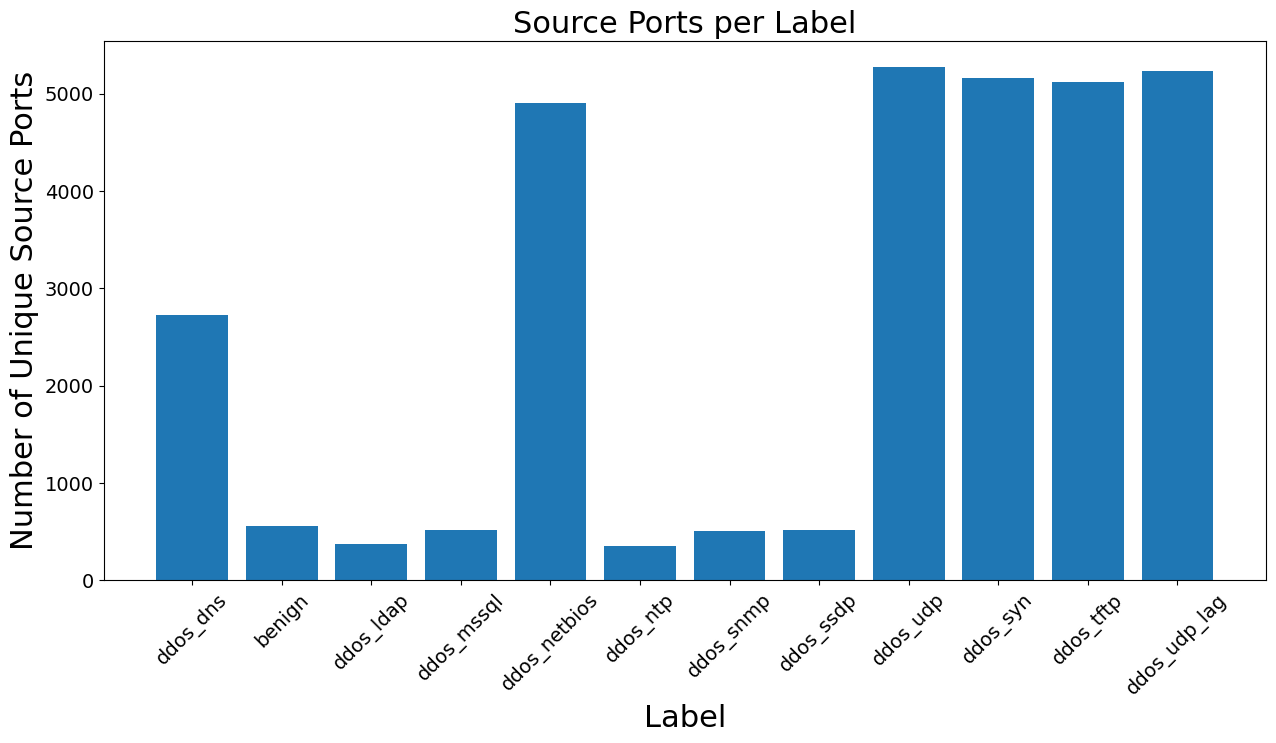

In [45]:
labels = []
n_ports = []
for label, df_ in df_dict.items():
    group_df = df_.groupby('Source Port')
    unique_ports = len(group_df['Source Port'].unique())
    labels.append(label)
    n_ports.append(unique_ports)
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x, n_ports, tick_label=labels)
ax.set_title('Source Ports per Label', fontsize=22)
ax.set_ylabel('Number of Unique Source Ports', fontsize=22)
ax.set_xlabel('Label', fontsize=22)
ax.tick_params(axis='x', rotation=45, labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.show()


Destination IP per label

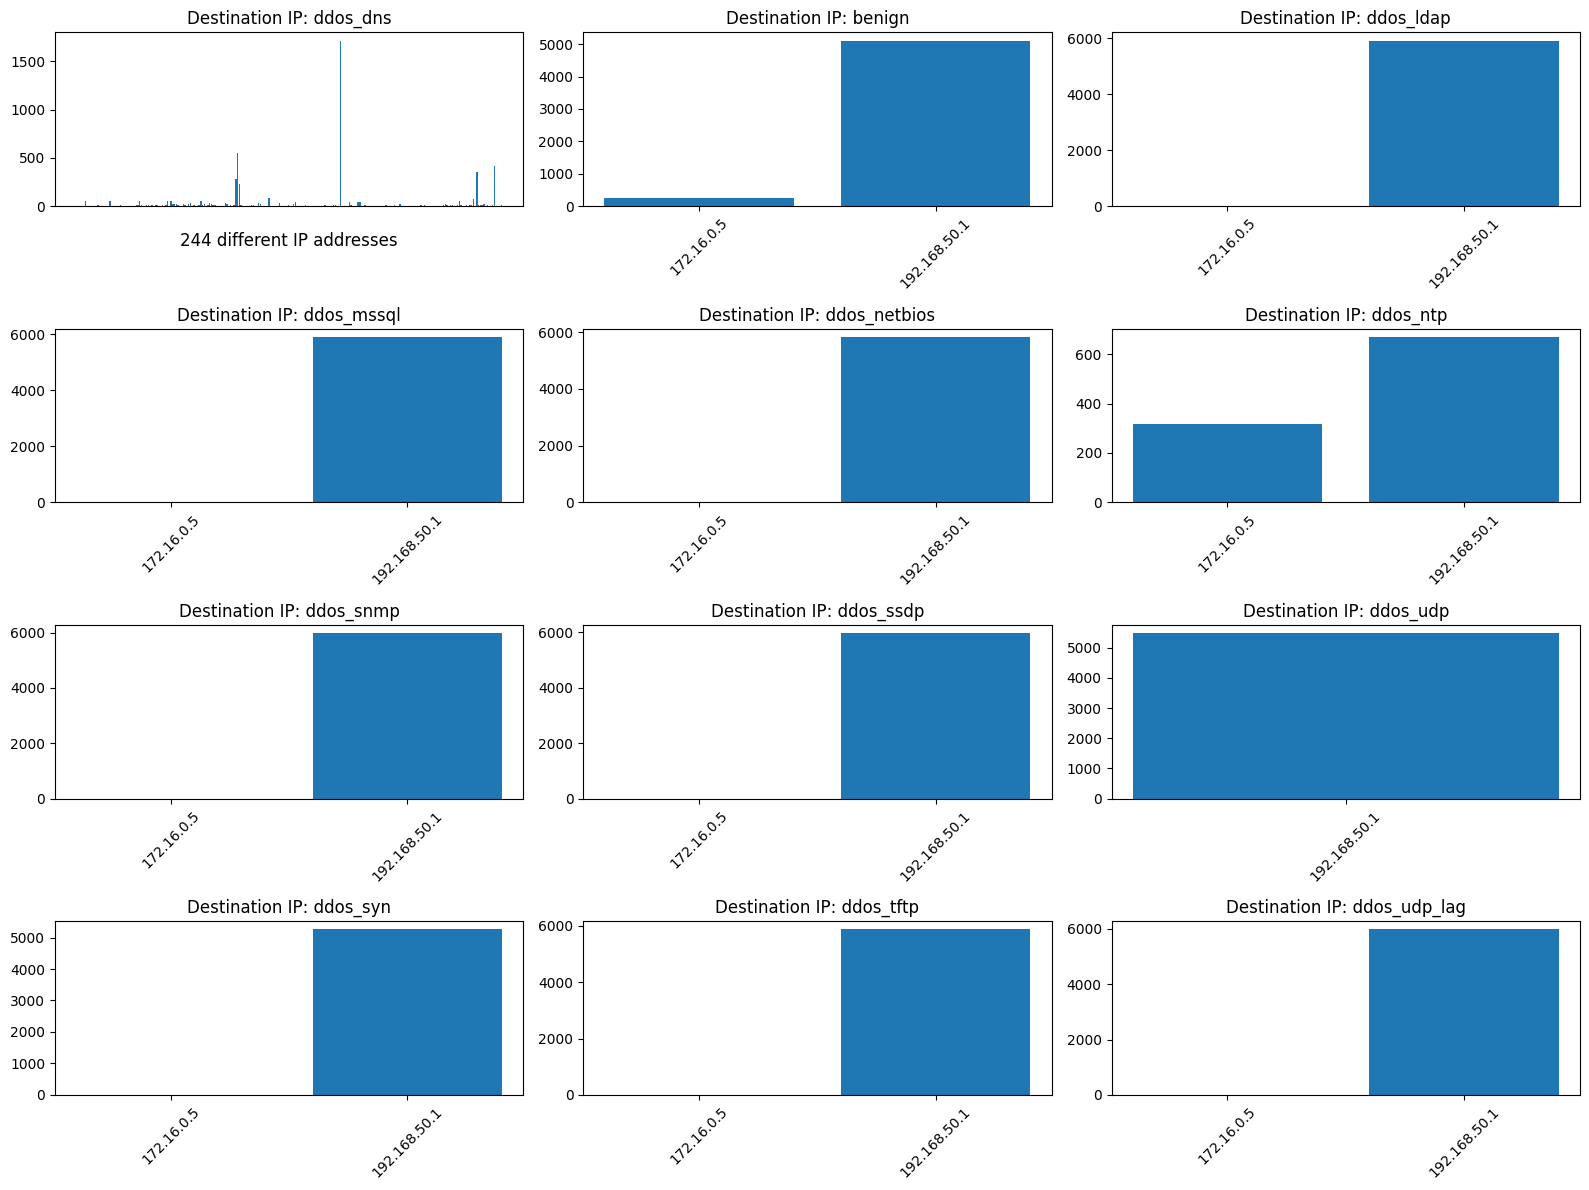

In [46]:
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, (label, df_) in enumerate(zip(df_dict.keys(), df_dict.values())):
    df_ = df_.groupby('Destination IP')
    dic = {key: group_df.shape[0] for key, group_df in df_}
    
    labels_in = list(dic.keys())
    x = np.arange(len(labels_in))
    values = list(dic.values())
    
    ax = axes[idx]
    if label == 'ddos_dns':
        ax.bar(x, values)
        ax.set_xticks([])
        ax.text(0.5, -0.2, f"{len(labels_in)} different IP addresses", 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
    else:
        ax.bar(x, values, tick_label=labels_in)
        ax.tick_params(axis='x', rotation=45)
    
    ax.set_title(f'Destination IP: {label}')

for idx in range(len(df_dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


Total Fwd Packets per Label

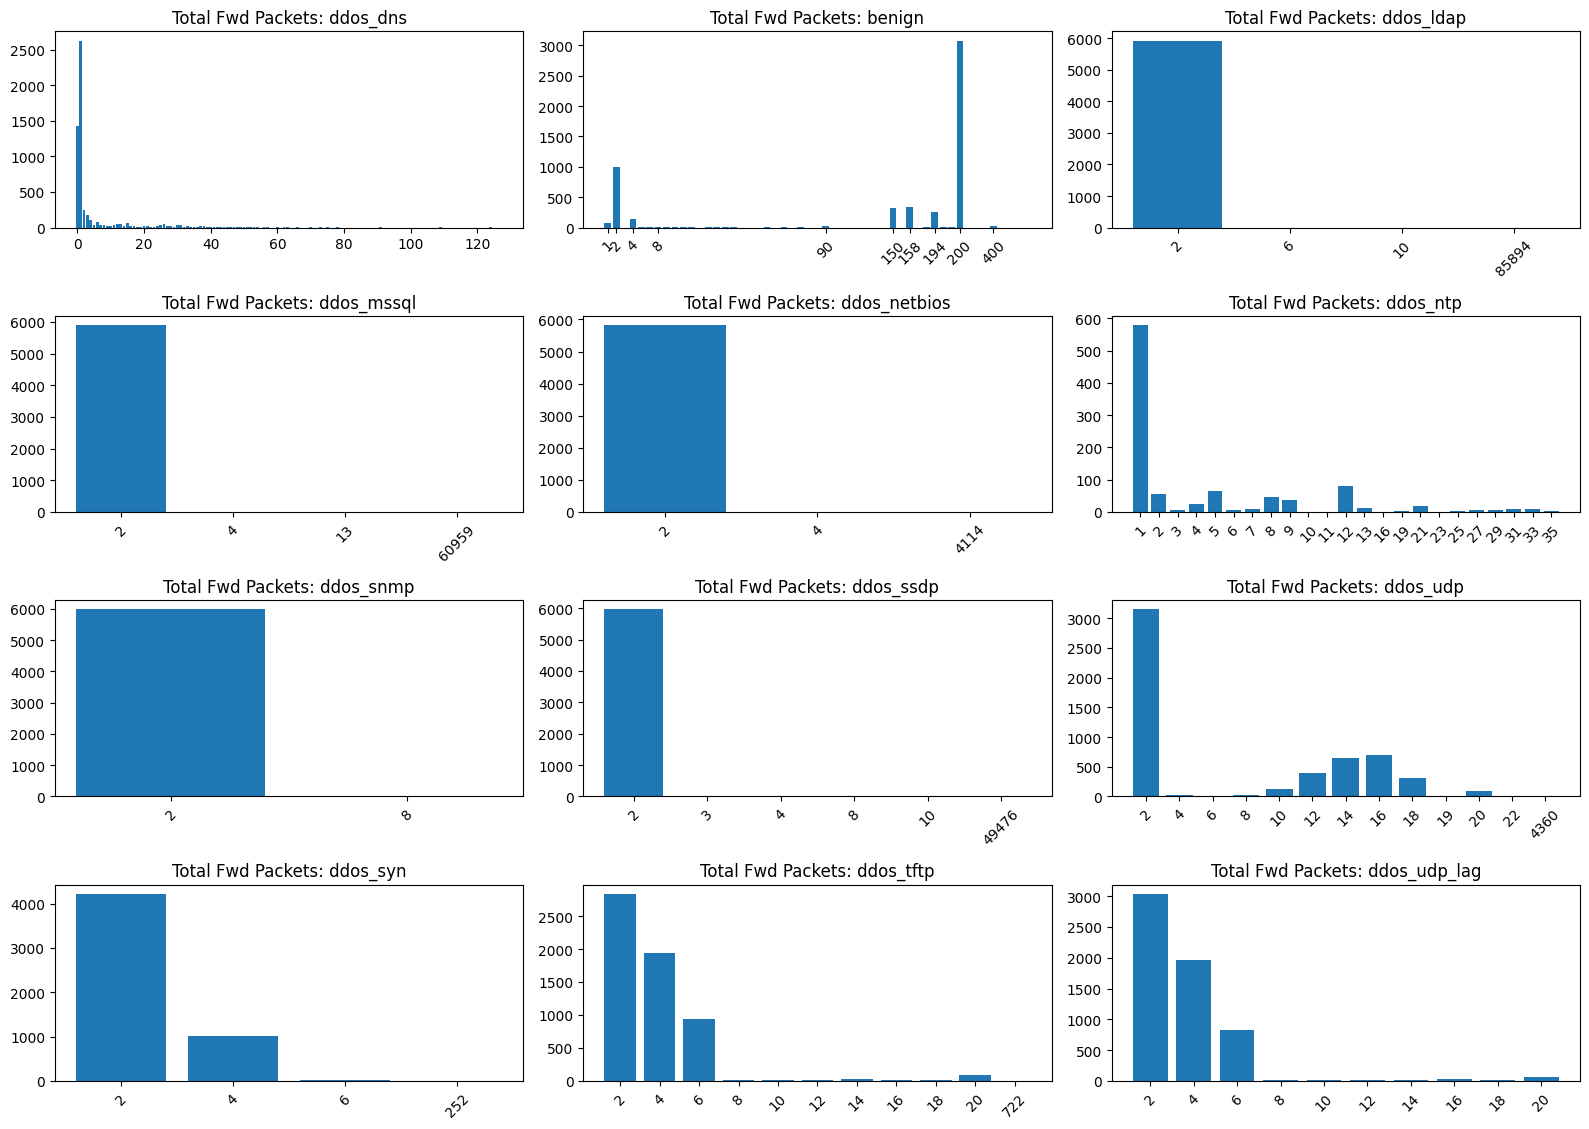

In [47]:
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, (label, df_) in enumerate(zip(df_dict.keys(), df_dict.values())):
    
    df_grouped = df_.groupby('Total Fwd Packets')
    dic = {key: group_df.shape[0] for key, group_df in df_grouped}
    
    labels_in = list(dic.keys())
    x = np.arange(len(labels_in))
    values = list(dic.values())
    
    ax = axes[idx]
    ax.bar(x, values)
    
    if label == 'benign':
       
        largest_indices = np.argsort(values)[-10:] 
        largest_indices = sorted(largest_indices) 
        largest_labels = [labels_in[i] for i in largest_indices]
        
        ax.set_xticks(largest_indices) 
        ax.set_xticklabels(largest_labels) 
        ax.tick_params(axis='x', rotation=45)  
    
    elif label != 'ddos_dns':
        ax.set_xticks(x) 
        ax.set_xticklabels(labels_in)
        ax.tick_params(axis='x', rotation=45)  

    ax.set_title(f'Total Fwd Packets: {label}')

for idx in range(len(df_dict), len(axes)):
    fig.delaxes(axes[idx])


plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


Total Backward Packets per Label

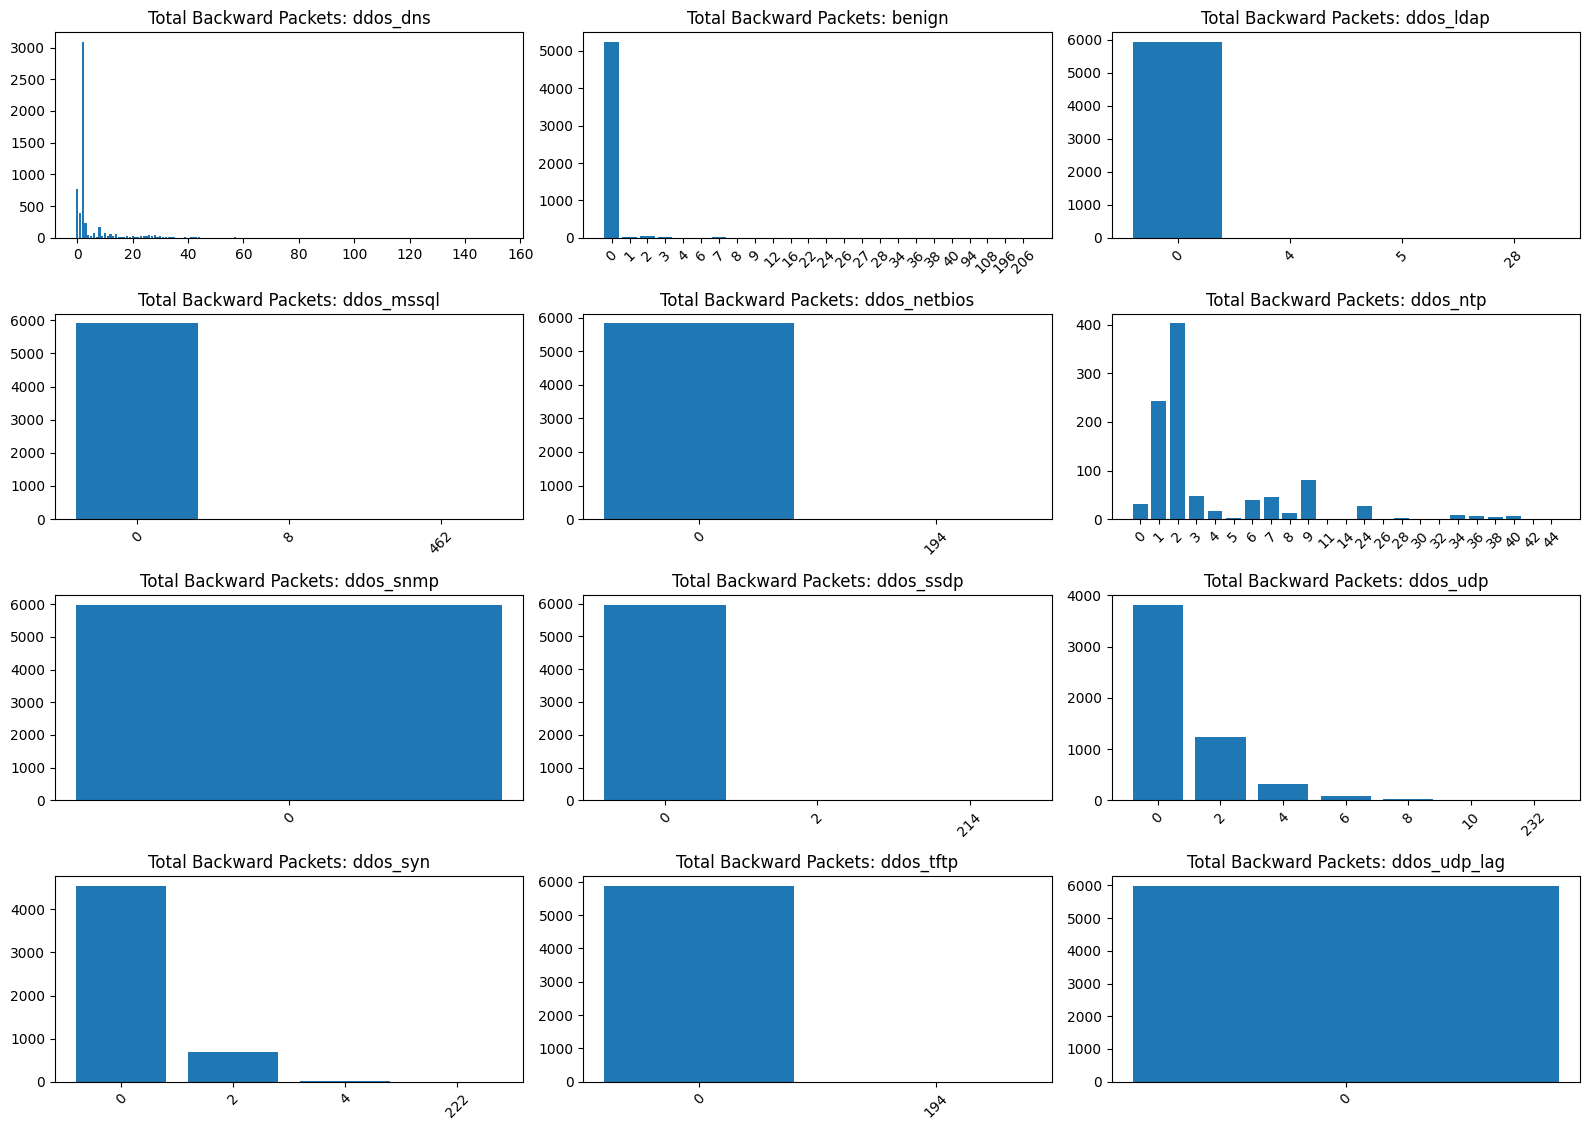

In [48]:
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, (label, df_) in enumerate(zip(df_dict.keys(), df_dict.values())):
    df_ = df_.groupby('Total Backward Packets')
    dic = {key: group_df.shape[0] for key, group_df in df_}
    
    labels_in = list(dic.keys())
    x = np.arange(len(labels_in))
    values = list(dic.values())
    
    ax = axes[idx]
    
    if label != 'ddos_dns':
        ax.tick_params(axis='x', rotation=45)
        ax.bar(x, values, tick_label=labels_in)
    else:
        ax.bar(x, values)

    ax.set_title(f'Total Backward Packets: {label}')

for idx in range(len(df_dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Flow duration per Label

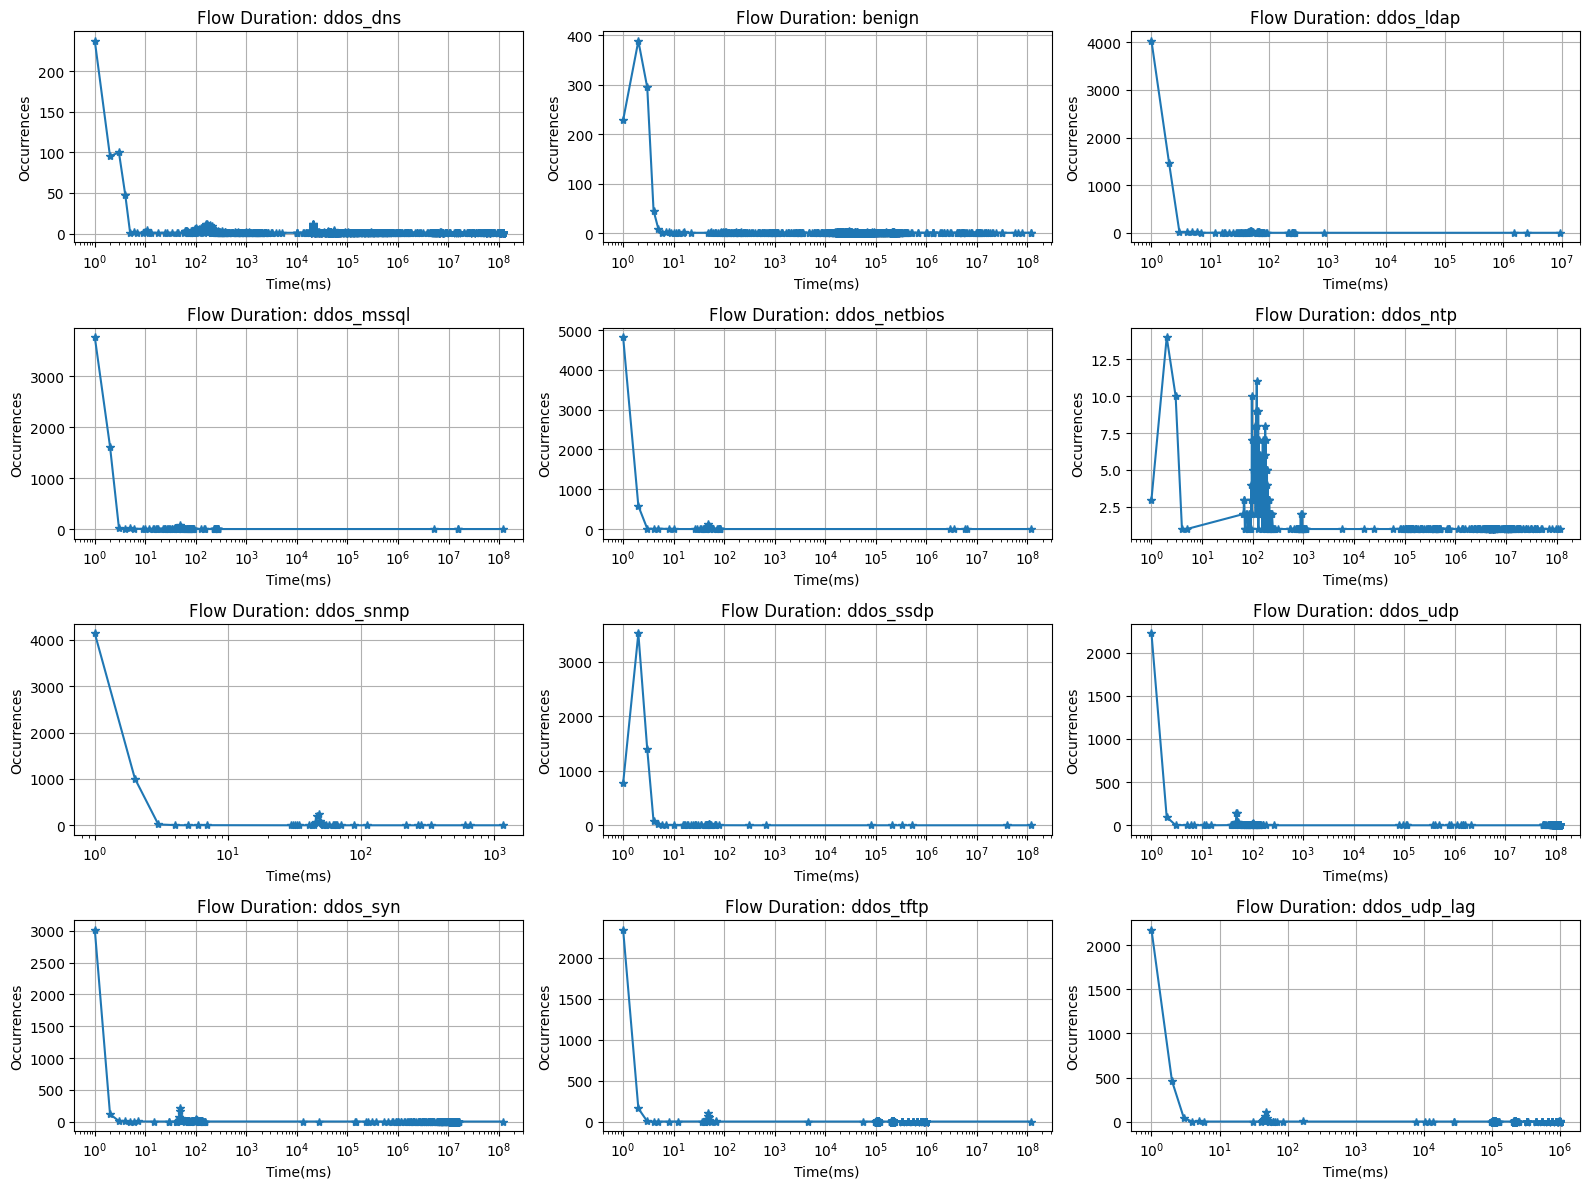

In [49]:
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten() 

for idx, (label, df_) in enumerate(zip(df_dict.keys(), df_dict.values())):
    pck_f = df_.groupby('Flow Duration')
    dic1 = {}
    li = []
    li1 = []
    
    for numb, group_df_prot in pck_f:
        li.append(numb)
        li1.append(group_df_prot.shape[0])
    
    dic1['value'] = li1
    pck_f_df = pd.DataFrame(data=dic1, index=li)

    ax = axes[idx]
    ax.plot(pck_f_df, marker='*')
    ax.set_xscale('log')
    ax.set_title(f'Flow Duration: {label}')
    ax.set_xlabel('Time(ms)')
    ax.set_ylabel('Occurrences')
    ax.grid()

for idx in range(len(df_dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


Source Port per label

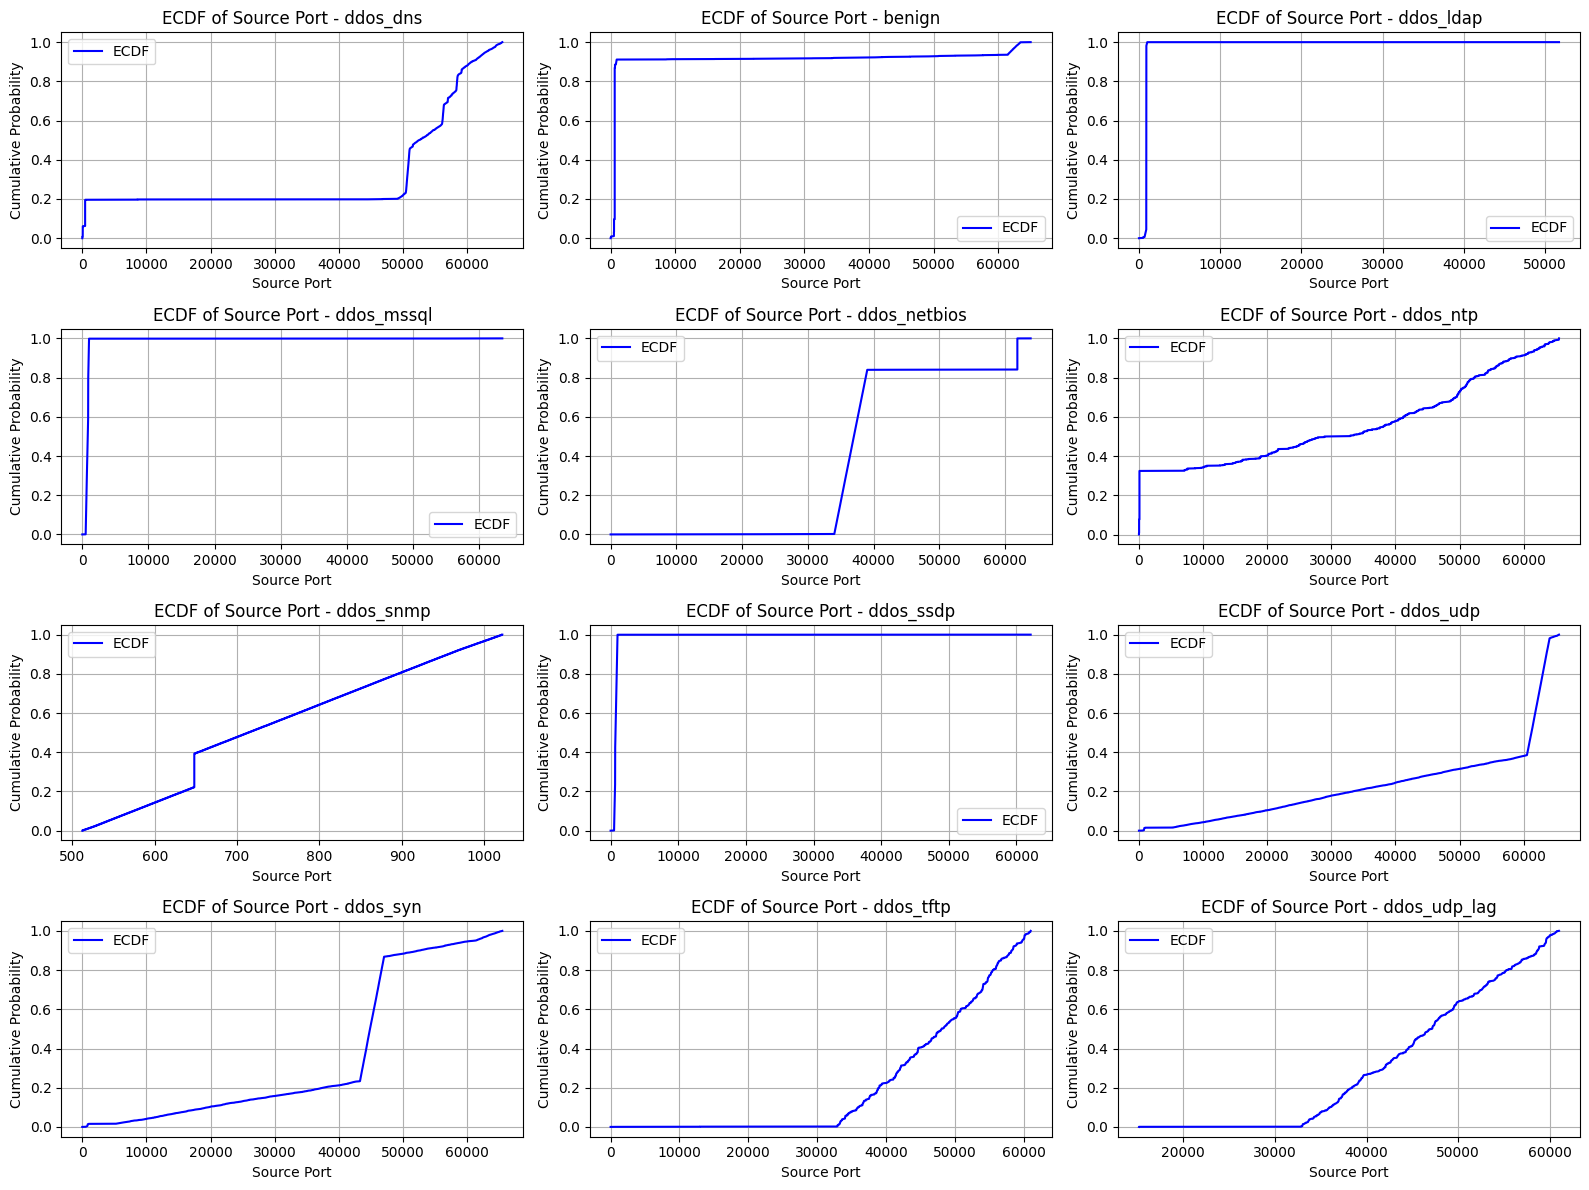

In [50]:
fig, axes = plt.subplots(4, 3, figsize=(16, 12)) 
axes = axes.flatten()  


for idx, (label, df_) in enumerate(zip(df_dict.keys(), df_dict.values())):
   
    ecdf_src_ports = ECDF(df_['Source Port'].values)

    ax = axes[idx]
    ax.plot(ecdf_src_ports.x, ecdf_src_ports.y, label='ECDF', color='blue')
    ax.set_xlabel('Source Port')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(f'ECDF of Source Port - {label}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [51]:
df['Forward Traffic Ratio'] = df['Total Fwd Packets'] / (df['Total Fwd Packets'] + df['Total Backward Packets'])

In [52]:
# Group the DataFrame by 'Label'
grouped = df.groupby('label')
# Create a list of DataFrames
list_of_dfs = [group for _, group in grouped]
labels = df['label'].unique()
print(labels)

df_dict = {}
for i in range(0,12):
    df_dict[labels[i]] = list_of_dfs[i]

['ddos_dns' 'benign' 'ddos_ldap' 'ddos_mssql' 'ddos_netbios' 'ddos_ntp'
 'ddos_snmp' 'ddos_ssdp' 'ddos_udp' 'ddos_syn' 'ddos_tftp' 'ddos_udp_lag']


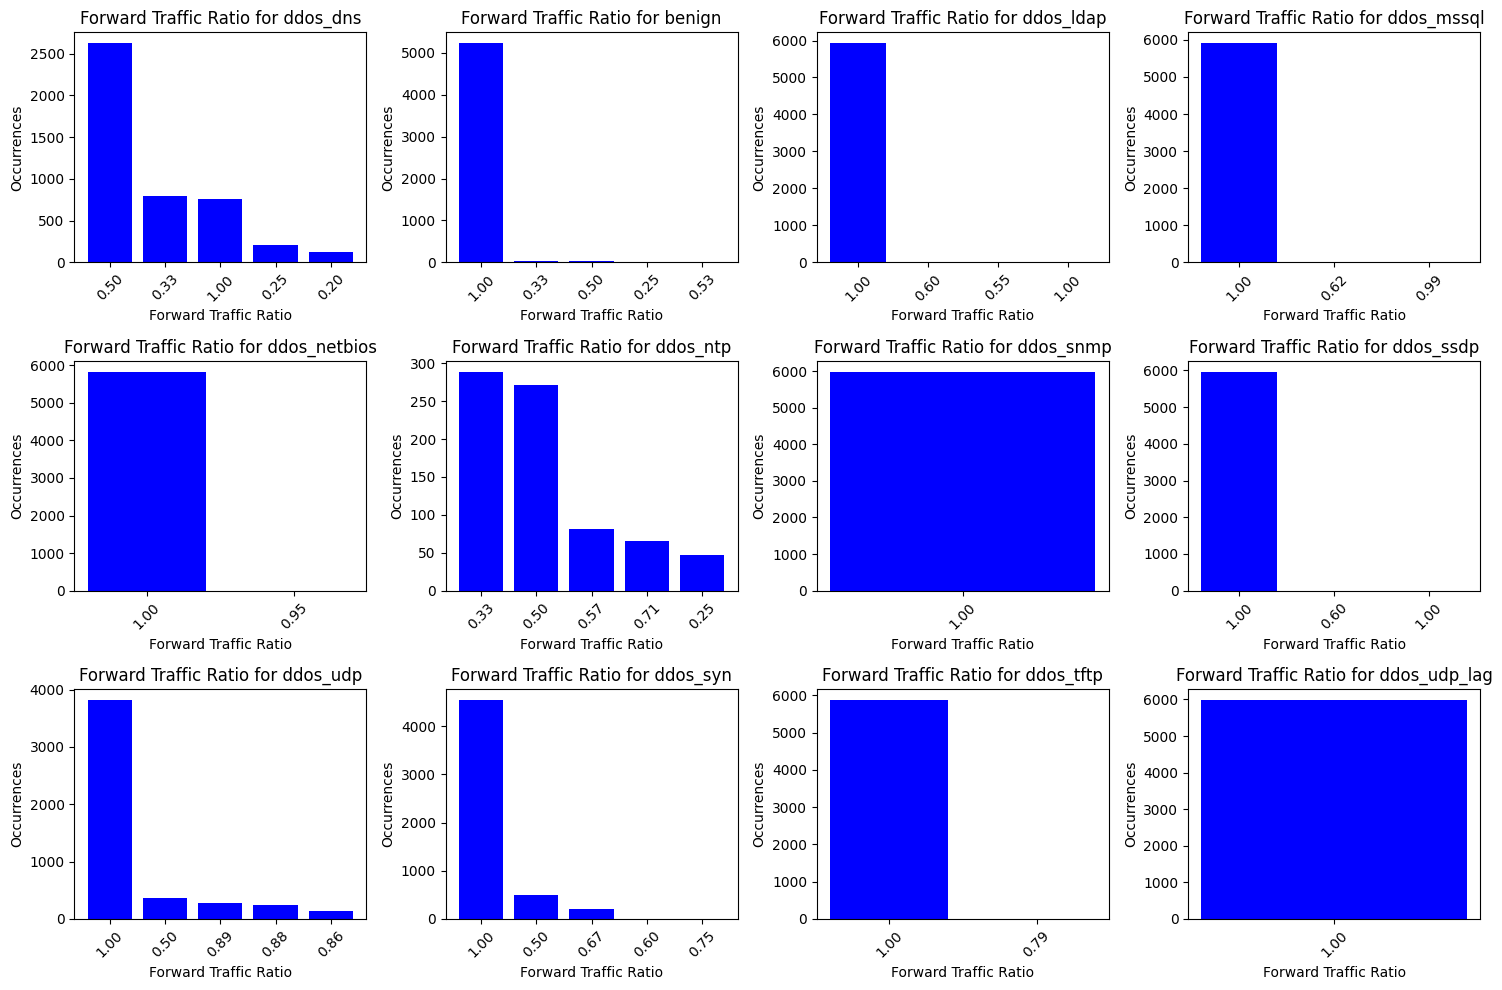

In [53]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i, (label, df_) in enumerate(zip(df_dict.keys(), df_dict.values())):
    traffic_ratio_counts = df_['Forward Traffic Ratio'].value_counts().head(5)
    labels_in = traffic_ratio_counts.index
    values = traffic_ratio_counts.values
    
    sorted_indices = np.argsort(values)[::-1]
    labels_in_sorted = labels_in[sorted_indices]
    values_sorted = values[sorted_indices]
    
    ax = axes[i]
    ax.bar(labels_in_sorted.astype(str), values_sorted, color='blue')
    
    ax.set_title(f'Forward Traffic Ratio for {label}')
    ax.set_xlabel("Forward Traffic Ratio")
    ax.set_ylabel("Occurrences")
    
    ax.set_xticks(np.arange(len(labels_in_sorted)))
    ax.set_xticklabels([f'{x:.2f}' for x in labels_in_sorted], rotation=45)

plt.tight_layout()
plt.show()


###  2. Data Pre-processing.


1. Choose features for dimensionality reduction

In [54]:
df_corr = df.copy()
# Find categorical features which are not useful for PCA and delete them
categorical_features = [
    'Flow ID','Source IP','Source Port','Destination IP','Destination Port',
    'Protocol','Timestamp','SimillarHTTP','Inbound','label'
]

df_corr = df_corr.drop(columns = categorical_features)

2. Compute the correlation matrix

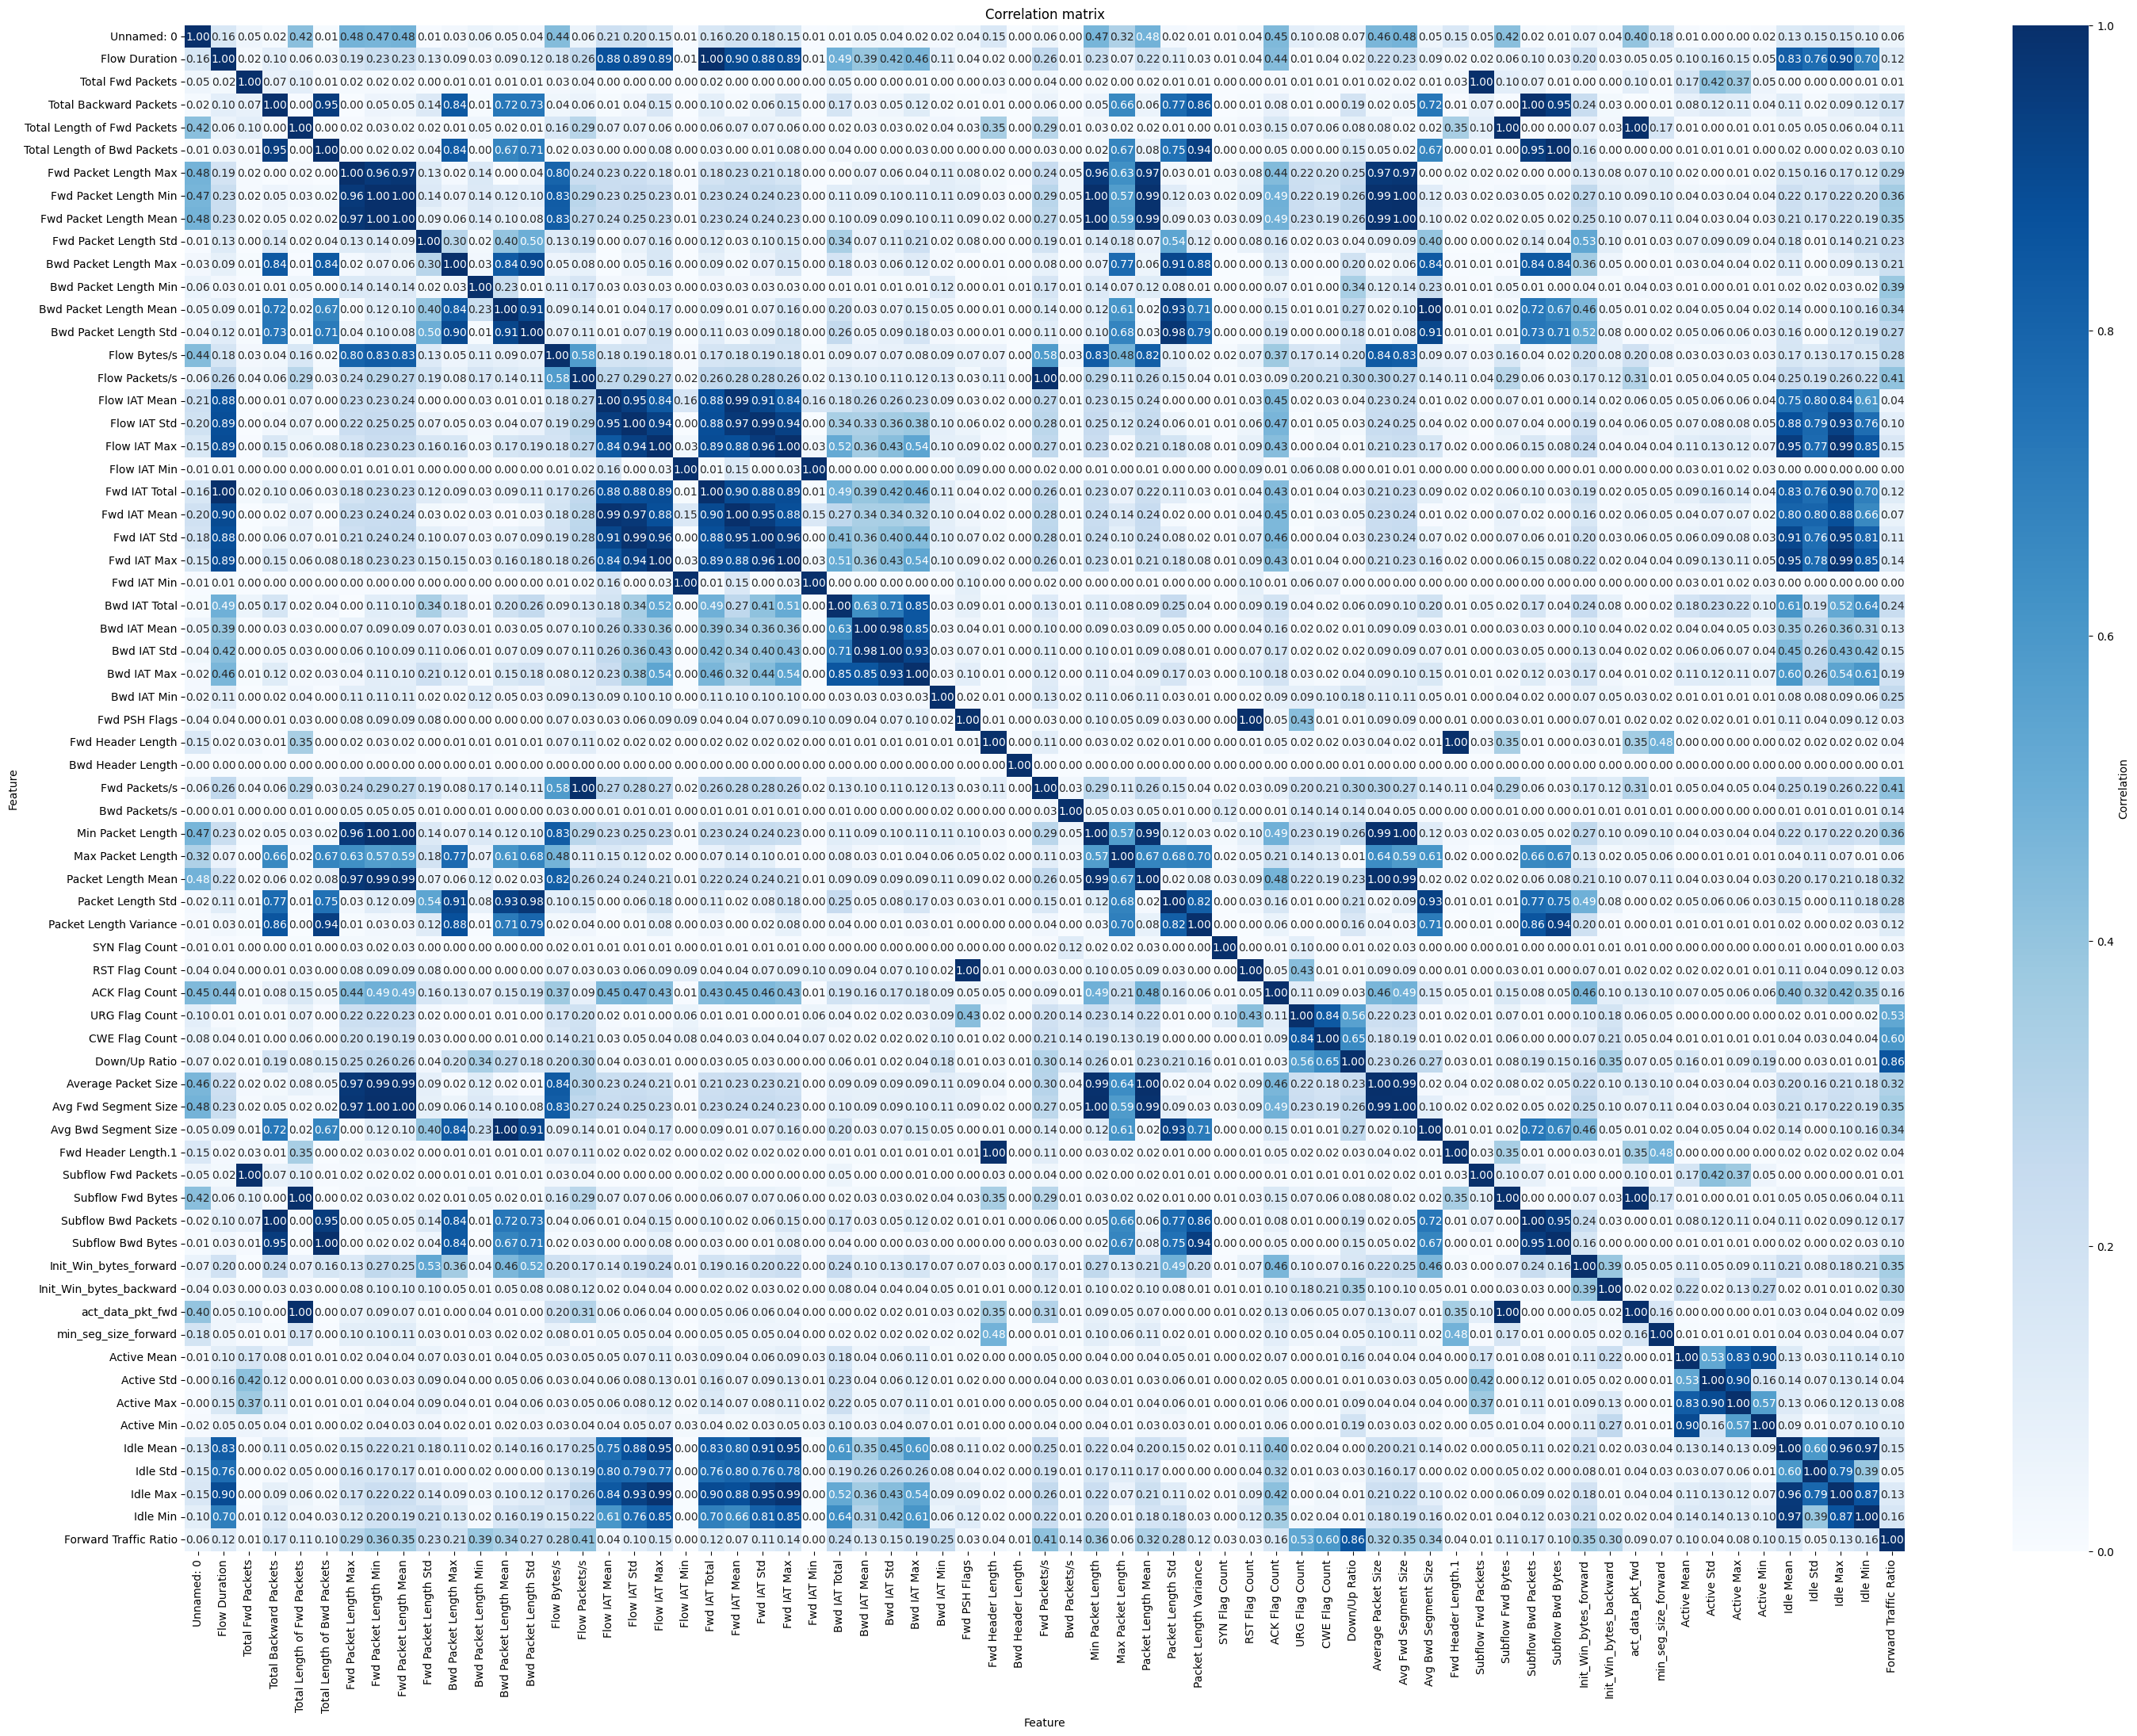

In [55]:
# Compute the correlation matrix
correlation_matrix = df_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(35,25))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'}, fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

3. Find redundant features

In [56]:
# Extract strongly correlated features (correlation > 0.8)
c = correlation_matrix[correlation_matrix > 0.8]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# Get strongly correlated features, removing pairs having correlation = 1 (correlation between one feature and itself)
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]
to_be_deleted = []
candidates = list(so["level_0"])

# Get the set of features hat could be deleted, only discard one feature per time (features can be correlated with multiple others)
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])): 
        to_be_deleted.append(candidate) # add the feature to the removed candidates
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)] # remove the rows that the removed feature is involved


print(len(to_be_deleted), 'features are highly correlated and could be removed ')

40 features are highly correlated and could be removed 


4. Performing PCA without standardizing data

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alvar\AppData\Local\Temp\ipykernel_9904\2920926133.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'2 PCs explain {round(perc_cumul_exp_var[1], 3)}% of $\sigma^2$', fontsize=22)


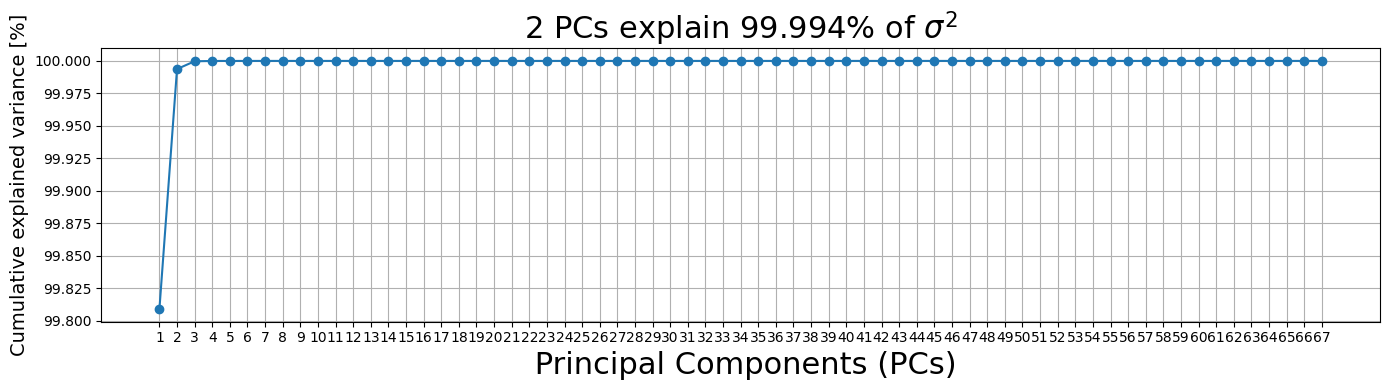

In [57]:
df_pca = df_corr.copy()
pca = PCA(random_state=15) # Initialize PCA
columns=df_pca.columns

pca.fit(df_pca[columns]) # Fit the PCA on the entire dataset
explained_variance = pca.explained_variance_ratio_ # Get the explained variance
cumul_exp_var = np.cumsum(explained_variance) # Get the cumulative explained variance
perc_cumul_exp_var = cumul_exp_var * 100 # Get the percentages

# Plot the cumulative explained variance wrt number of components
plt.figure(figsize=(14, 4))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel(' Principal Components (PCs)', fontsize=22)
plt.ylabel('Cumulative explained variance [%]', fontsize=14)
plt.xticks([i for i in range(len(columns))], [i for i in range(1,(len(columns)+1))])
plt.grid()
plt.title(f'2 PCs explain {round(perc_cumul_exp_var[1], 3)}% of $\sigma^2$', fontsize=22)
plt.tight_layout()
plt.show()


5. Standarize data

In [58]:
# define the scaler
scaler = StandardScaler()
# for each column in the dataset, fit and transform the data
df_s = df_corr.copy()
columns=df_s.columns
df_s[columns] = scaler.fit_transform(df_s[columns])
# See scaled data
df_s.head()

,Unnamed: 0,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Forward Traffic Ratio
0,-1.717028,-0.227684,0.169121,-0.051748,1.754276,-0.023697,-0.297075,-0.254784,-0.271665,-0.172277,...,0.202023,-0.044128,-0.034259,-0.044084,-0.037205,-0.216341,-0.165955,-0.2224,-0.194882,0.360456
1,-1.716975,-0.228947,-0.036372,-0.051748,-0.283738,-0.023697,-0.297075,-0.254784,-0.271665,-0.172277,...,0.202023,-0.044128,-0.034259,-0.044084,-0.037205,-0.216341,-0.165955,-0.2224,-0.194882,0.360456
2,-1.716922,-0.226789,0.391920,-0.051748,3.963912,-0.023697,-0.297075,-0.254784,-0.271665,-0.172277,...,0.202023,-0.044128,-0.034259,-0.044084,-0.037205,-0.216341,-0.165955,-0.2224,-0.194882,0.360456
3,-1.716870,-0.226799,0.391920,-0.051748,3.963912,-0.023697,-0.297075,-0.254784,-0.271665,-0.172277,...,0.202023,-0.044128,-0.034259,-0.044084,-0.037205,-0.216341,-0.165955,-0.2224,-0.194882,0.360456
4,-1.716817,-0.227524,0.391920,-0.051748,3.963912,-0.023697,-0.297075,-0.254784,-0.271665,-0.172277,...,0.202023,-0.044128,-0.034259,-0.044084,-0.037205,-0.216341,-0.165955,-0.2224,-0.194882,0.360456


6. Create df_processed.csv for unsupervised learning

In [59]:
df_processed = df_s.copy()
label = df['label']

# Drop the high correlation features
df_processed = df_processed.drop(columns=to_be_deleted)

# Encode the protocol and the source port
df_encoded_protocol = pd.get_dummies(df['Protocol'], prefix='Protocol', dtype=int)

df_processed['Source_Port_Category'] = df['Source Port'].apply(lambda x: 'Below_1024' if x < 1024 else '1024_and_Above')
df_encoded_ports = pd.get_dummies(df_processed['Source_Port_Category'], prefix='Source_Port', dtype=int)
df_processed = df_processed.drop(columns=['Source_Port_Category'])

df_processed = pd.concat([df_processed, df_encoded_protocol, df_encoded_ports, label], axis=1)

df_processed.to_csv("df_processed.csv")
df_processed


,Unnamed: 0,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow IAT Min,Bwd IAT Total,Bwd IAT Min,...,min_seg_size_forward,Active Std,Idle Mean,Idle Std,Protocol_0,Protocol_6,Protocol_17,Source_Port_1024_and_Above,Source_Port_Below_1024,label
0,-1.717028,0.169121,-0.297075,-0.172277,-0.069596,-0.146261,-0.765426,-0.015452,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,0,1,ddos_dns
1,-1.716975,-0.036372,-0.297075,-0.172277,-0.069596,-0.146261,-0.324952,-0.015448,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,0,1,ddos_dns
2,-1.716922,0.391920,-0.297075,-0.172277,-0.069596,-0.146261,-0.765114,-0.015452,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,0,1,ddos_dns
3,-1.716870,0.391920,-0.297075,-0.172277,-0.069596,-0.146261,-0.765106,-0.015452,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,0,1,ddos_dns
4,-1.716817,0.391920,-0.297075,-0.172277,-0.069596,-0.146261,-0.764174,-0.015456,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,1.754872,-0.036372,-0.408056,-0.172277,-0.069596,-0.146261,-0.013555,-0.015452,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,1,0,ddos_udp_lag
64235,1.754925,-0.027720,-0.377323,0.521580,-0.069596,-0.146261,-0.766925,-0.015452,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,1,0,ddos_udp_lag
64236,1.754977,-0.036372,-0.408056,-0.172277,-0.069596,-0.146261,-0.013555,-0.015452,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,1,0,ddos_udp_lag
64237,1.755030,-0.032046,-0.384152,0.501315,-0.069596,-0.146261,-0.766921,-0.015452,-0.112384,-0.113608,...,0.202023,-0.034259,-0.216341,-0.165955,0,0,1,1,0,ddos_udp_lag


7. PCA Analysis

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alvar\AppData\Local\Temp\ipykernel_9904\1775801641.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'30 PCs explain {round(perc_cumul_exp_var[29], 3)}% of $\sigma^2$', fontsize=22)


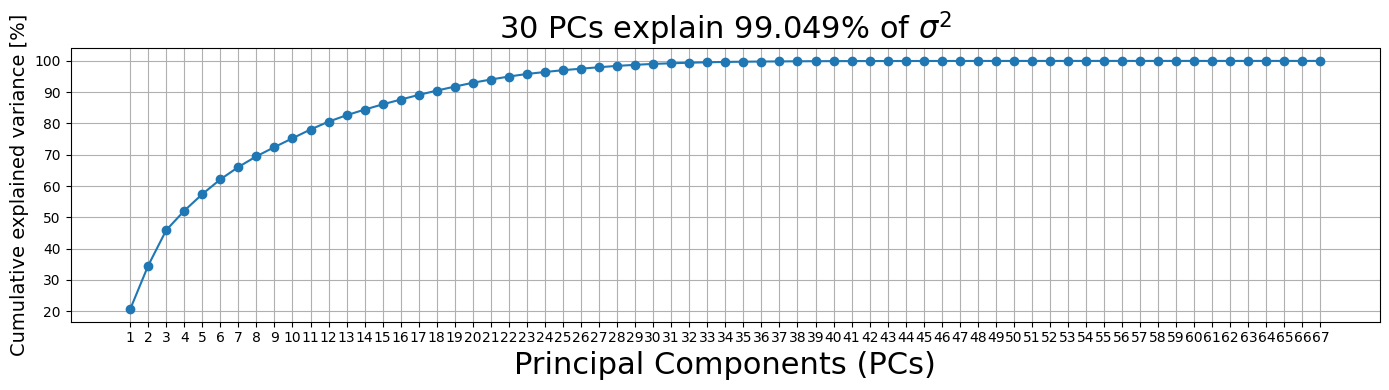

In [60]:
pca = PCA(random_state=15)
pca.fit(df_s[columns])
explained_variance = pca.explained_variance_ratio_ 
cumul_exp_var = np.cumsum(explained_variance) 
perc_cumul_exp_var = cumul_exp_var*100 

plt.figure(figsize=(14,4))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('Principal Components (PCs)', fontsize=22)
plt.ylabel('Cumulative explained variance [%]', fontsize=14)
plt.xticks([i for i in range(len(columns))], [i for i in range(1,(len(columns)+1))])
plt.grid()
plt.title(f'30 PCs explain {round(perc_cumul_exp_var[29], 3)}% of $\sigma^2$', fontsize=22)
plt.tight_layout()
plt.show()


#### Create training and testing pca dataset for the supervised learning

In [61]:
df = pd.read_csv("ddos_dataset.csv")
df.columns = df.columns.str.strip()
df = df.drop(columns=df.columns[df.eq(0).all()])
categorical_features = [
    'Flow ID','Source IP','Source Port','Destination IP','Destination Port',
    'Protocol','Timestamp','SimillarHTTP','Inbound'
]
df = df.drop(columns=categorical_features)

# Perform train and test split
x_train, x_test, y_train, y_test = train_test_split(
    df[df.columns[:-1]],  # X
    df['label'],  # y
    stratify=df['label'], 
    train_size=0.7,
    random_state=15
)

# Standardize the datasets
scaler = StandardScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train[x_train.columns])
x_test[x_test.columns] = scaler.transform(x_test[x_test.columns])

# Perform PCA: Fit only on training data and apply to both datasets
pca = PCA(n_components=30, random_state=15)
pca.fit(x_train[x_train.columns])  
pca_result_1 = pca.transform(x_train[x_train.columns]) 
pca_result_2 = pca.transform(x_test[x_test.columns])  

pca_train = pd.DataFrame(pca_result_1, columns=[f'PC{i}' for i in range(1, 30+1)], index=x_train.index).assign(label=y_train)
pca_test = pd.DataFrame(pca_result_2, columns=[f'PC{i}' for i in range(1, 30+1)], index=x_test.index).assign(label=y_test)

pca_train.to_csv("pca_training.csv")
pca_test.to_csv("pca_testing.csv")

C:\Users\alvar\AppData\Local\Temp\ipykernel_9904\2134428960.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ddos_dataset.csv")


Check Label distribution for train and test set

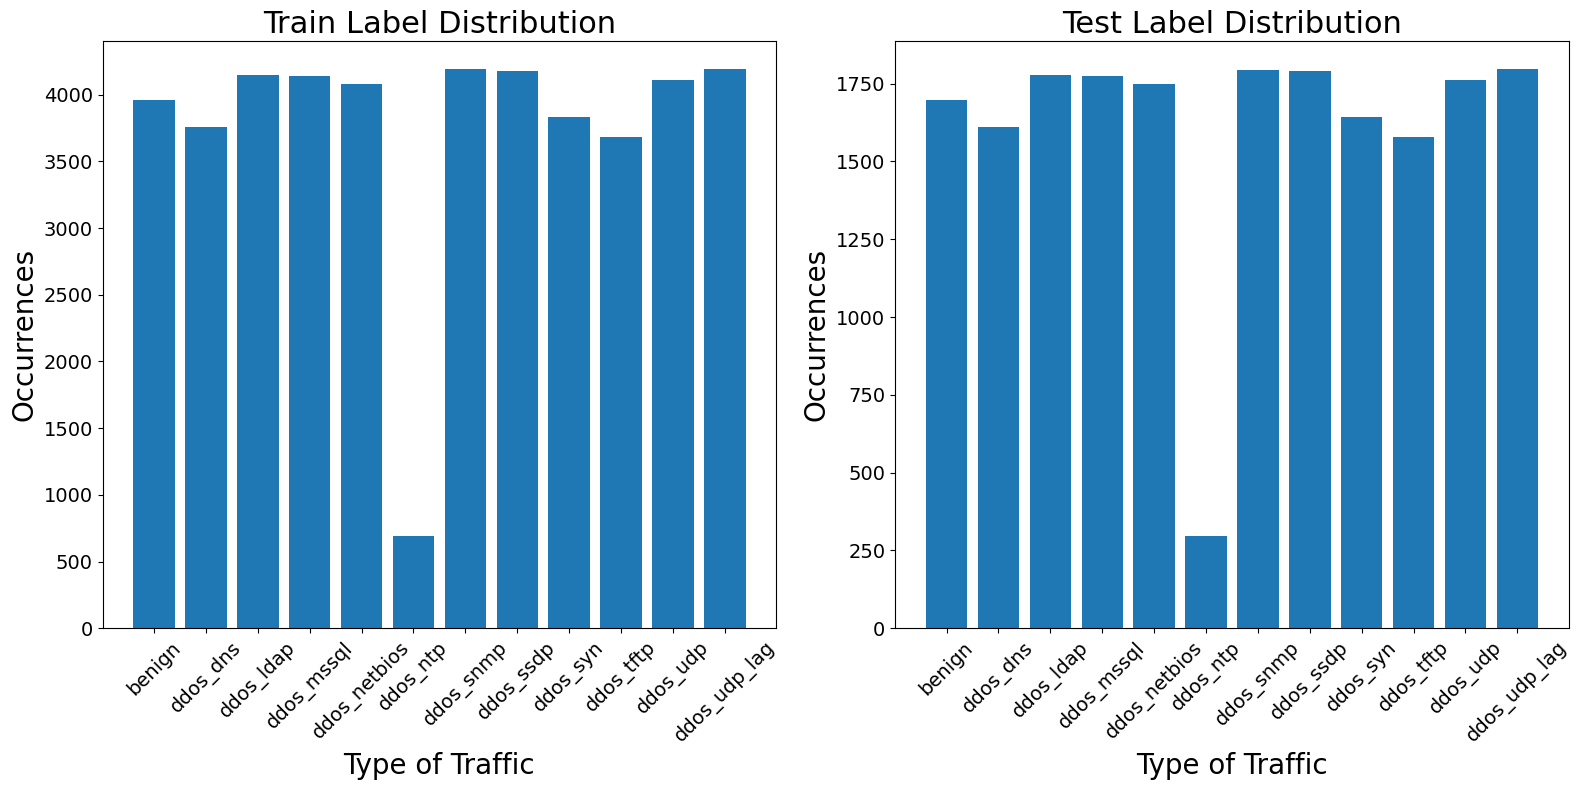

In [62]:
# Group and calculate occurrences for training data
grouped_train = pca_train.groupby('label')
train_dic = {key: group_df.shape[0] for key, group_df in grouped_train}
train_labels = list(train_dic.keys())
train_values = list(train_dic.values())

# Group and calculate occurrences for testing data
grouped_test = pca_test.groupby('label')
test_dic = {key: group_df.shape[0] for key, group_df in grouped_test}
test_labels = list(test_dic.keys())
test_values = list(test_dic.values())

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

x_train = np.arange(len(train_labels))
axs[0].bar(x_train, train_values, tick_label=train_labels)
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_title('Train Label Distribution', fontsize=22)
axs[0].set_ylabel('Occurrences', fontsize=20)
axs[0].set_xlabel('Type of Traffic', fontsize=20)
axs[0].tick_params(axis='both', labelsize=14)

x_test = np.arange(len(test_labels))
axs[1].bar(x_test, test_values, tick_label=test_labels)
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title('Test Label Distribution', fontsize=22)
axs[1].set_ylabel('Occurrences', fontsize=20)
axs[1].set_xlabel('Type of Traffic', fontsize=20)
axs[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

